In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
AR_fut = xr.open_mfdataset("*_AR_detection_p93_ssp585.nc")

In [3]:
AR_fut

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 31025)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
Data variables:
    ivt      (lat, time, lon) bool dask.array<chunksize=(96, 365, 144), meta=np.ndarray>

In [21]:
AR_fut_yr_ARC = AR_fut.sel(lat=slice(60,90))
AR_fut_yr_ARC = AR_fut_yr_ARC.groupby(AR_fut_yr_ARC.time.dt.year).sum()
AR_fut_yr_ARC = AR_fut_yr_ARC.reduce(np.sum,dim=('lat','lon'))

AR_fut_yr_ANT = AR_fut.sel(lat=slice(-90,-60))
AR_fut_yr_ANT = AR_fut_yr_ANT.groupby(AR_fut_yr_ANT.time.dt.year).sum()
AR_fut_yr_ANT = AR_fut_yr_ANT.reduce(np.sum,dim=('lat','lon'))

In [13]:
AR_fut_yr_ARC

<xarray.Dataset>
Dimensions:  (year: 85)
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2095 2096 2097 2098 2099
Data variables:
    ivt      (year) int64 dask.array<chunksize=(1,), meta=np.ndarray>

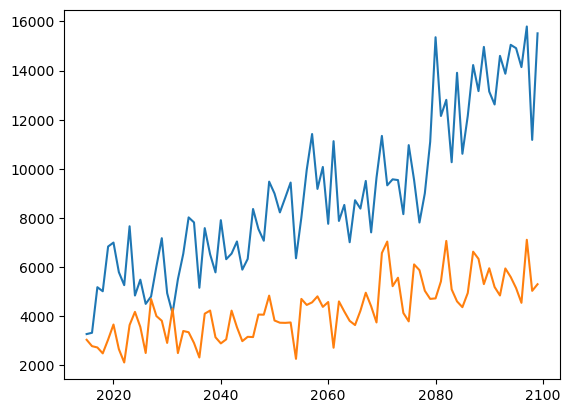

In [22]:
plt.plot(AR_fut_yr_ARC.year,AR_fut_yr_ARC.ivt)
plt.plot(AR_fut_yr_ANT.year,AR_fut_yr_ANT.ivt)

In [14]:
out_ar = ar_points.copy()
ar_points.close()

out_ar = out_ar.drop_vars(['quantile','member_id'])

out_loc = np.zeros((out_ar.ivt.shape[0],out_ar.ivt.shape[1],out_ar.ivt.shape[2])).astype(int)

res_lon = abs(lon_.values[1]-lon_.values[0])
res_lat = abs(np.min(np.diff(lat_.values)))

test_val = out_ar.ivt.values[:]

for tt in range(len(out_ar.time)):
    df_loc = test_val[:,tt,:]
    ll = plt.contour(df_loc,levels=[0,1])
    plt.close()
    for item in ll.collections:
        for i in item.get_paths():
            v = i.vertices
            crit = abs(np.max(v[:, 1])-np.min(v[:, 1]))
            if (crit>=20): # AR has to be at least 20 deg lat 
                xx=(v[:, 0]).astype(int)
                yy=(v[:, 1]).astype(int)
                for (x,y) in zip(xx,yy):
                    out_loc[y,tt,x] = 1
    

/tmp/ipykernel_2784/1875809623.py:15: UserWarning: No contour levels were found within the data range.
  ll = plt.contour(df_loc,levels=[0,1])


In [15]:
out_ar.ivt.values = out_loc.astype(bool)

In [16]:
out_ar.to_netcdf(str(year)+'_crit_p91.nc')
out_ar.close()

In [17]:
AR = xr.open_dataset(str(year)+'_crit_p91.nc')

In [18]:
ivt_ = AR.ivt
ivt = xr.concat([ivt_,ivt_[:,:,:5]],dim='lon')# add extra points for AR at the edge of the world

In [19]:
out_ar = ivt.copy()
out_ar.values[:] = out_ar.values[:]*0.0

def floodfill(indata):
    outloc = np.copy(indata)
    for x in range(indata.shape[0]):
        # for each latitude get limit longitudes of shapes
        ind_lim = np.where(indata[x,:]==1)
        for ii in ind_lim:
            if len(ii)>1: # if there is a shape at that longitude
                jj=0
                while jj<=len(ii)-2:
                    if abs(ii[jj]-ii[jj+1])>10: # avoid filling where only 1 point in shape
                        jj=jj+1
                    else:
                        outloc[x,ii[jj]:ii[jj+1]]=1
                        jj=jj+1
    return outloc


for k in range(ivt.shape[0]):
    matrix = ivt[k,:,:]
    tst = floodfill(matrix)
    out_ar[k,:,:] = tst
    
# add the values of the extra points to get ARs at the end of the world
out_ar[:,:,:5] = out_ar[:,:,:5]+out_ar[:,:,144:]
out_ar = out_ar[:,:,:144]
out_ar = xr.where(out_ar>1,1,out_ar)
out_ar = out_ar.astype(bool)

lat_ = AR.lat
lon_ = AR.lon

out_ar.to_netcdf(str(year)+'_AR_detection_p91.nc')